In [140]:
from sympy import *
from collections import OrderedDict
from sympy import solve_poly_system

def get_solved_trial_solution(diff_eq, u_cap, coefficients, bcs):
    u_cap_substituted, coeff_set = substitute_bcs(u_cap, coefficients, bcs)

    coefficients_as_symbols = [symbols(a) for a in coefficients]
    remaining_coefficients = coeff_set.copy()

    print("Remaining coefficient(s): ", remaining_coefficients)

    #equation_components = list(diff_eq.atoms())
    equation_components = diff_eq.free_symbols

    equation_substituted = diff_eq.copy()

    for equation_component in equation_components:
        if 'D' in equation_component.name:
            equation_substituted = equation_substituted.subs(equation_component, differentiate(equation_component.name, u_cap_substituted))
    domain_residual = equation_substituted
    print("coeff_sets: ", coeff_set)

    #domain_residual = diff_eq.subs('D2u', differentiate('D2u', u_cap_substituted)) # If other orders of u differentiation is there in equation, substitue for each of them
    # Find a way to identify each of these differiations of u without having to explicitly specify them
    display("Domain Residual:")
    display(domain_residual)
    Rd = domain_residual.lhs

    #print("U cap:")
    #display(u_cap)
    
    #print("U cap as terms:")
    #display(u_cap.as_terms())
    #display(u_cap.as_two_terms())
    """
    no_of_terms_in_u_cap = len(u_cap.as_terms()[0])
    print("Number of terms in u_cap: ", no_of_terms_in_u_cap)

    u_cap_terms = []

    #Loop through each term in u_cap, divide by respective coefficient:

    for n in range(no_of_terms_in_u_cap):
        current_term = u_cap.as_terms()[0][n][0]
        for coefficient in coefficients:
            if symbols(coefficient) in current_term.free_symbols:
                current_term = sympify(current_term / symbols(coefficient))
                #print("Appending term: ", current_term)
        u_cap_terms.append(current_term)

    """
    print("U cap substituted:")
    display(u_cap_substituted)
    wt_residual_equations = []

    for remaining_coefficient in remaining_coefficients:
        weighted_residual_term = u_cap_substituted.coeff(remaining_coefficient)
        
        term_to_integrate = sympify(Rd * weighted_residual_term)
        wt_residual_equation = integrate(term_to_integrate, ('x', 0, symbols('L')))
        print("current weighted residual equation: ")
        display(wt_residual_equation)
        wt_residual_equations.append(wt_residual_equation)
    display(wt_residual_equations)
    final_coefficients = solve(wt_residual_equations, *coefficients_as_symbols) #What is the difference between solve_poly_system and solve?
    print(final_coefficients)

    """

    coefficients_as_symbols = [symbols(coefficient) for coefficient in coefficients] # Since solve doesnt perform type casting on string

    # Looping through each term in u_cap again
    #Generate wt_residual_equation by multiplying each of these terms with Rd
    #Append to list of wt_residual_equations

    #Galerkin's Weighted residual Based Solving

    for u_cap_term in  u_cap_terms:
        term_to_integrate = sympify(Rd * u_cap_term)
        wt_residual_equation = integrate(term_to_integrate, ('x', 0, symbols('L')))
        print("current weighted residual equation: ")
        display(wt_residual_equation)
        wt_residual_equations.append(wt_residual_equation)
    display(wt_residual_equations)
    final_coefficients = solve(wt_residual_equations, *coefficients_as_symbols) #What is the difference between solve_poly_system and solve?
    print(final_coefficients)

    """

    for coefficient in remaining_coefficients:
        u_cap_substituted = u_cap_substituted.subs(coefficient, final_coefficients[coefficient])
    u_cap_answer = u_cap_substituted

    display(u_cap_answer)
    return u_cap_answer


In [141]:
import numpy as np
import math
def u_cap_generate():
    x = symbols('x')
    L = symbols('L')

    sinpixbyL = sin(pi*x/L)

    display(sympify(symbols('c1') * sinpixbyL))
    return sympify(symbols('c1') * sinpixbyL), ['c1']

def generate_diff_eq():
    x = symbols('x')
    v = symbols('v')
    D4v = symbols('D4v')
    lhs = symbols('E') * symbols('I') * D4v - symbols('q0')
    diff_eq = Eq(lhs, 0)
    display(diff_eq)
    return diff_eq

In [142]:
def substitute_bcs(u_cap, coefficients, bcs):
    equations_to_solve = []
    for bc in bcs:
        variables = list(bc.keys())
        print(variables)
        if 'D' in variables[1]:             # It is ensured that each entry of the bcs list is an ordered dictionary where the first key is 'x' and the second is either 'v' or a differentiated version of 'v'
            print("yip condition, das heisst es gibt differential term in this boundary condition")
            differentiated_u = differentiate(variables[1], u_cap)
            equation_to_solve = Eq(differentiated_u.subs({'x':bc['x']}), bc[variables[1]])
            #display(equation_to_solve)
            equations_to_solve.append(equation_to_solve)
            #equation_to_solve = Eq(u_cap.subs())
        else:
            print("yelse condition, das heisst es gibt kein(e?n?) differential term in this boundary condition")
            equation_to_solve = Eq(u_cap.subs({'x':bc['x']}), bc[variables[1]])
            #display(equation_to_solve)
            equations_to_solve.append(equation_to_solve)
    print("Equations to solve:")
    display(equations_to_solve)

    solution = {}

    index = -1

    while(len(solution.keys()) < len(bcs)):
        index+=1
        print("Index = ", index)
        coeff_set = [symbols(coeff) for coeff in coefficients]
        print("coeff set: ", coeff_set)
        coeff_to_solve_for = coeff_set.pop(index) # So that we can have value taking and remove take place together
        #print("coeff_to_solve_for :", coeff_to_solve_for)
        equations_to_solve = list(set(equations_to_solve))  # Taking only unique equations, since substitution of different bcs can potentially
        if True in equations_to_solve:
            equations_to_solve.remove(True)
            print("After removing, equations are: ", equations_to_solve)
        if len(equations_to_solve) > 0:
            print("Now solving the equations: ", equations_to_solve)
            solution = solve(equations_to_solve, *coeff_set)   # Solve_poly_system function is not type-casting. We need to explicitly provide symbol objects as arguments. Otherwise, "solve()" is a better function to use, since it provides dictionaries as output, not a list
        # The fact that c0, c1, etc are to be provided as arguments, needs to be taken care of.
        #For example the u_cap function could return a list whose first item is the expression and next is a list of coefficients. perhaps a third which is a list of variables, for zukunftige Nutzung.
            print("Solution:", solution)
            #Now, coeff_set seems to have too many items. Pop out the coefficients that have already been solved for, as available in the keys of solution
        else:
            coeff_set.append(coeff_to_solve_for)
            break

    coeff_set = list(set([symbols(coeff) for coeff in coefficients]) - set(solution.keys()))

    print("solution: ", solution)
    
    print("coeff_set: ", coeff_set)
    if solution:
        substitution_dictionary = solution.copy()
        print("subs dict", substitution_dictionary)

        display(solution)
        u_cap_substituted = u_cap.subs(substitution_dictionary)
        display("u_cap_substituted", u_cap_substituted)
    else:
        u_cap_substituted = u_cap

    return u_cap_substituted, coeff_set    # Need to check if the coefficients being returned are arbitrary, based on number of iterations, or consistent
    
def differentiate(Dexp, u_cap):
    no_of_times = int(Dexp[1])    #Assuming single digit times differentiating. If more, you guys do it, I'm bored
    print(no_of_times)
    ans = diff(u_cap, 'x', no_of_times)
    display(ans)
    return ans
    #return differentiated_u


In [143]:
diff_eq = generate_diff_eq()
u_cap, coefficients = u_cap_generate()

bcs = [OrderedDict({'x':'0', 'v':0}), OrderedDict({'x':'L', 'v':0}), OrderedDict({'x':'0', 'D2v':0}), OrderedDict({'x':'L', 'D2v':0})]
print(bcs)
solution_answer = get_solved_trial_solution(diff_eq, u_cap, coefficients, bcs)

Eq(D4v*E*I - q0, 0)

c1*sin(pi*x/L)

[OrderedDict([('x', '0'), ('v', 0)]), OrderedDict([('x', 'L'), ('v', 0)]), OrderedDict([('x', '0'), ('D2v', 0)]), OrderedDict([('x', 'L'), ('D2v', 0)])]
['x', 'v']
yelse condition, das heisst es gibt kein(e?n?) differential term in this boundary condition
['x', 'v']
yelse condition, das heisst es gibt kein(e?n?) differential term in this boundary condition
['x', 'D2v']
yip condition, das heisst es gibt differential term in this boundary condition
2


-pi**2*c1*sin(pi*x/L)/L**2

['x', 'D2v']
yip condition, das heisst es gibt differential term in this boundary condition
2


-pi**2*c1*sin(pi*x/L)/L**2

Equations to solve:


[True, True, True, True]

Index =  0
coeff set:  [c1]
After removing, equations are:  []
solution:  {}
coeff_set:  [c1]
Remaining coefficient(s):  [c1]
4


pi**4*c1*sin(pi*x/L)/L**4

coeff_sets:  [c1]


'Domain Residual:'

Eq(pi**4*E*I*c1*sin(pi*x/L)/L**4 - q0, 0)

U cap substituted:


c1*sin(pi*x/L)

current weighted residual equation: 


pi**4*E*I*c1/(2*L**3) - 2*L*q0/pi

[pi**4*E*I*c1/(2*L**3) - 2*L*q0/pi]

{c1: 4*L**4*q0/(pi**5*E*I)}


4*L**4*q0*sin(pi*x/L)/(pi**5*E*I)

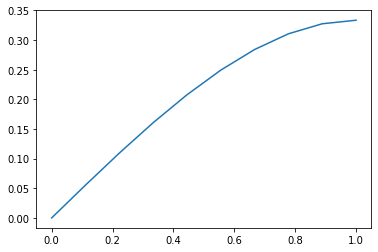

In [135]:
import matplotlib.pyplot as plt
import numpy

solution_answer = solution_answer.subs('A', 1)
solution_answer = solution_answer.subs('E', 1)
solution_answer = solution_answer.subs('a', 1)
solution_answer = solution_answer.subs('L', 1)

lam_v = lambdify('x', solution_answer, modules=[numpy])

x_vals = numpy.linspace(0, 1, 10)
y_vals = lam_v(x_vals)

#print(x_vals)
#print(y_vals)

plt.plot(x_vals, y_vals)